# 1. Load and Preprocess Image Data

In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
from pathlib import Path
from tqdm import tqdm

In [2]:
directory = str(Path.cwd())

all_img_dir = [i for i in os.listdir(directory+'/Images') if 'n0' in i]
Name = []
for file in all_img_dir: 
    name = file.split('-')[-1]
    Name += [name]
print(Name)
print(len(Name))

['redbone', 'Samoyed', 'affenpinscher', 'West_Highland_white_terrier', 'whippet', 'Cardigan', 'Greater_Swiss_Mountain_dog', 'malamute', 'coated_retriever', 'Leonberg', 'Japanese_spaniel', 'briard', 'English_springer', 'Brittany_spaniel', 'schipperke', 'papillon', 'Old_English_sheepdog', 'clumber', 'collie', 'miniature_pinscher', 'Italian_greyhound', 'Border_collie', 'Irish_setter', 'Labrador_retriever', 'Boston_bull', 'Walker_hound', 'Saint_Bernard', 'Lakeland_terrier', 'Welsh_springer_spaniel', 'Saluki', 'African_hunting_dog', 'English_foxhound', 'haired_fox_terrier', 'Afghan_hound', 'silky_terrier', 'Irish_terrier', 'groenendael', 'Newfoundland', 'coated_wheaten_terrier', 'dingo', 'keeshond', 'American_Staffordshire_terrier', 'beagle', 'Weimaraner', 'vizsla', 'Eskimo_dog', 'Tibetan_terrier', 'golden_retriever', 'Dandie_Dinmont', 'kuvasz', 'Irish_water_spaniel', 'haired_pointer', 'Sealyham_terrier', 'Bouvier_des_Flandres', 'Airedale', 'tan_coonhound', 'Irish_wolfhound', 'standard_pood

In [3]:
def search_boundary(bd_path):
    with open(bd_path, 'r') as f:
        content = f.read()
        bds = []
        
        axes = ['xmin', 'xmax', 'ymin', 'ymax']
        for ax in axes:
            start = content.find('<'+ax+'>') +6
            end = content.find('</'+ax+'>')    
            
            bd = int(content[start:end])
            bds.append(bd) 

        
    return bds[0], bds[1], bds[2], bds[3]

In [4]:
def target_locator(img, xmin, xmax, ymin, ymax):
    if len(img.shape) == 3:
        image = img[ymin:ymax, xmin:xmax, :]
    else:
        image = img[ymin:ymax, xmin:xmax]
        
    return image

### Here is an example image:

(375, 500, 3)


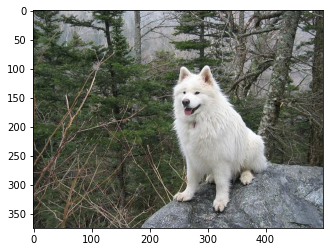

In [5]:
smy_img_dir = os.path.join(directory+'/Images', 'n02111889-Samoyed')
im_code = 'n02111889_8870.jpg'
smy_img = os.path.join(smy_img_dir+'/', im_code)
im1 = np.flip(cv2.imread(smy_img), axis=-1)

print(im1.shape)
plt.imshow(im1)

***Now, apply predefined functions to chop out the part wihtin the bounding box***

(256, 171, 3)


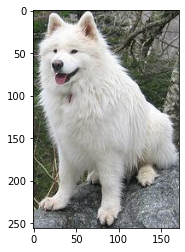

In [6]:
smy_bd_dir = os.path.join(directory+'/Annotation', 'n02111889-Samoyed')
smy_bd_path = os.path.join(smy_bd_dir+'/',im_code[:-4])
xmin, xmax, ymin, ymax=search_boundary(smy_bd_path)
image1 = target_locator(im1, xmin, xmax, ymin, ymax)
print(image1.shape)
plt.imshow(image1)

In [7]:
def load_image(N=len(Name), dsize=(128, 128)):
    train_data = [] #np.array([])
    test_data = [] #np.array([])
    train_label = [] #np.array([]) 
    test_label = [] #np.array([])

    for i in tqdm(range(N)): #len(Name)
        
        img_dir = os.path.join(directory+'/Images', all_img_dir[i])
        bd_dir = os.path.join(directory+'/Annotation', all_img_dir[i])
        
        n = len(os.listdir(img_dir))
        t = 0
        
        for im in os.listdir(img_dir):
            
            img_path = os.path.join(img_dir+'/', im)
            bd_path = os.path.join(bd_dir+'/', im[:-4])
            
            # Default is to read img in RGB scale
            img = np.flip(cv2.imread(img_path), #if grayscale: cv2.IMREAD_GRAYSCALE
                            axis=-1) 
            
            xmin, xmax, ymin, ymax = search_boundary(bd_path)
            image = target_locator(img, xmin, xmax, ymin, ymax)
    
            # skip faulty images
            if not np.any(image):
                t+=1
                continue
            
            image = cv2.resize(image, dsize=dsize)            
            image = image/255.0
            
            if t <= np.floor(n*0.8):
                train_data.append(image)
                train_label.append(Name[i])          
            else:
                test_data.append(image)
                test_label.append(Name[i])
        
            t+=1
    
    return train_data, test_data, train_label, test_label


### Read image data


In [39]:
# train_data, test_data, train_label, test_label = load_image(color_mode='grayscale',
#                                                             target_size=(128,128))
n_class = 10

train_data, test_data, train_label, test_label = load_image(N=n_class, dsize=(128,128))

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


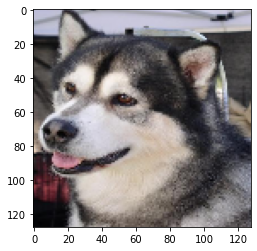

In [40]:
plt.imshow(train_data[1002])

In [41]:
# convert data and labels to np array 
x_train = np.array(train_data)
x_test = np.array(test_data)

train_label = np.array(train_label)
test_label = np.array(test_label)


# flatten data to feed into SVM classifier
X_train = x_train.reshape((x_train.shape[0], 
                           x_train.shape[1]**2 * x_train.shape[-1]))
X_test = x_test.reshape((x_test.shape[0],
                            x_test.shape[1]**2 * x_test.shape[-1]))

# Let's print out the new data shapes
print('train shape is now: ' + str(X_train.shape))
print('test  shape is now: ' + str(X_test.shape))

train shape is now: (1395, 49152)
test  shape is now: (340, 49152)


In [42]:
train_label.shape

(1395,)

In [13]:
train_df = pd.DataFrame(X_train)
train_df['label'] = train_label

test_df = pd.DataFrame(X_test)
test_df['label'] = test_label

In [14]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,label
0,0.207843,0.109804,0.047059,0.215686,0.117647,0.054902,0.219608,0.113725,0.047059,0.243137,...,0.101961,0.050980,0.011765,0.101961,0.047059,0.007843,0.101961,0.050980,0.011765,redbone
1,0.713725,0.670588,0.694118,0.764706,0.717647,0.745098,0.772549,0.729412,0.752941,0.780392,...,0.247059,0.235294,0.172549,0.270588,0.274510,0.203922,0.203922,0.207843,0.137255,redbone
2,0.600000,0.600000,0.600000,0.552941,0.552941,0.552941,0.545098,0.545098,0.545098,0.588235,...,0.709804,0.701961,0.713725,0.713725,0.701961,0.717647,0.705882,0.698039,0.709804,redbone
3,0.901961,0.905882,0.807843,0.913725,0.913725,0.811765,0.882353,0.890196,0.796078,0.886275,...,0.031373,0.047059,0.058824,0.035294,0.050980,0.062745,0.035294,0.050980,0.058824,redbone
4,0.262745,0.235294,0.200000,0.360784,0.298039,0.247059,0.360784,0.298039,0.227451,0.341176,...,0.439216,0.435294,0.419608,0.447059,0.443137,0.431373,0.419608,0.415686,0.400000,redbone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0.439216,0.254902,0.105882,0.439216,0.231373,0.078431,0.450980,0.235294,0.082353,0.447059,...,0.250980,0.156863,0.062745,0.243137,0.156863,0.066667,0.239216,0.156863,0.074510,Leonberg
1391,0.603922,0.670588,0.584314,0.705882,0.776471,0.713725,0.705882,0.792157,0.788235,0.819608,...,0.396078,0.529412,0.329412,0.368627,0.501961,0.309804,0.427451,0.560784,0.376471,Leonberg
1392,0.513725,0.529412,0.439216,0.556863,0.576471,0.486275,0.274510,0.294118,0.196078,0.309804,...,0.592157,0.654902,0.682353,0.580392,0.639216,0.666667,0.568627,0.631373,0.654902,Leonberg
1393,0.380392,0.388235,0.337255,0.698039,0.686275,0.611765,0.705882,0.678431,0.584314,0.745098,...,0.654902,0.694118,0.454902,0.682353,0.717647,0.490196,0.678431,0.713725,0.482353,Leonberg


In [ ]:
# train_df.to_csv("data/train_data.csv")
# test_df.to_csv("data/test_data.csv")

# 2. Algorithm implementation

# Baseline: kernel SVM

In [12]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN

# evaluation
from sklearn.model_selection import (train_test_split, KFold, GridSearchCV)
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, auc, roc_curve)

In [ ]:
# train_df = pd.read_csv('data/train_data.csv', index_col=[0])
# test_df = pd.read_csv('data/test_data.csv', index_col=[0])

In [ ]:
# train_df

In [ ]:
X_train = train_df.iloc[:,:-1].values
y_train = train_df['label'].values

In [ ]:
X_test = test_df.iloc[:,:-1].values
y_test = test_df['label'].values

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
img = X_train[231].reshape((128,128,3))
plt.imshow(img)

In [ ]:
model = SVC()
param_grid = {#'kernel':('linear', 'rbf'),
             'C': [0.1, 1, 10]}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
clf = GridSearchCV(estimator=model, 
                   param_grid=param_grid, 
                   cv=kf,
                   verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)

# View the Grid Search CV Results
pd.DataFrame(clf.cv_results_)

In [ ]:
svm = SVC(kernel='rbf', C=10).fit(X_train, y_train)
y_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred)

print("Classifier: SVM; Test accuracy: %f" % svm_acc)
print(confusion_matrix(y_test, y_pred))

## CNN

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import time

In [43]:
batch_size = 15
num_epoch = 40

In [44]:
x_train.shape, x_test.shape

((1395, 128, 128, 3), (340, 128, 128, 3))

In [45]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
 
# y_train_int = LabelEncoder().fit_transform(y_train)
# y_train_int = y_train_int.reshape(len(y_train_int), 1)
# train_label = OneHotEncoder(sparse=False).fit_transform(y_train_int)

# y_test_int = LabelEncoder().fit_transform(y_test)
# y_test_int = y_test_int.reshape(len(y_test_int), 1)
# test_label = OneHotEncoder(sparse=False).fit_transform(y_test_int)

train_label = np.array([Name.index(label) for label in train_label])
test_label = np.array([Name.index(label) for label in test_label])

print(train_label.shape)
print(train_label)
print(test_label.shape)

(1395,)
[0 0 0 ... 9 9 9]
(340,)


In [46]:
train_ratio = 0.9
train_data, valid_data, train_label, valid_label = train_test_split(x_train, train_label, 
                                                                  train_size=train_ratio,
                                                                  shuffle=True,
                                                                  random_state=42)
train_data.shape, valid_data.shape

((1255, 128, 128, 3), (140, 128, 128, 3))

In [47]:
# calc mean and std for tensor normalization
train_mean = tuple(np.mean(train_data, axis=(0,1,2))) 
train_std = tuple(np.std(train_data, axis=(0,1,2)))

val_mean = tuple(np.mean(test_data, axis=(0,1,2)))
val_std = tuple(np.std(test_data, axis=(0,1,2)))

test_mean = tuple(np.mean(test_data, axis=(0,1,2)))
test_std = tuple(np.std(test_data, axis=(0,1,2)))

train_mean, val_mean

((0.46589363212569107, 0.4366174655033815, 0.38626398360432124),
 (0.47205589848806095, 0.4385757822895939, 0.38577371668947313))

In [48]:
# training set transformation with data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(), # image to Tensor and normalize to [0,1]
    transforms.Normalize(mean=train_mean, std=train_std)
#     transforms.ToTensor()
])

# testing set without data augmentation
val_transform = transforms.Compose([   
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=val_mean, std=val_std)
#     transforms.ToTensor()
])

test_transform = transforms.Compose([  
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std)
#     transforms.ToTensor()
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [22]:
# train_data = train_data.astype('float32')
# train_label = train_label.astype('float32')
# test_data = x_test.astype('float32')
# test_label = test_label.astype('float32')
# train_data.dtype

In [23]:
train_set = ImgDataset(train_data, train_label, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

valid_set = ImgDataset(valid_data, valid_label, transform=val_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size , shuffle=True)

In [ ]:
train_set 

In [49]:
# for data in train_loader:
#     inputs, labels = data
#     print(data.shape)

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dim [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
#             nn.Linear(512*8*8, 1024),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = x.float()
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

## Training 

In [51]:
model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
    
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
        batch_loss = loss(outputs, labels)
        batch_loss.backward() 
        optimizer.step() 
        
        _,train_pred = torch.max(outputs.data, 1)
        train_acc += (train_pred == labels).sum().item()
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            _,val_pred = torch.max(outputs.data, 1)
            
            val_acc += (val_pred == y).sum().item()         
            val_loss += loss(outputs, y).item()

  
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(),
             val_acc/valid_set.__len__(), val_loss/valid_set.__len__()))

[001/040] 14.02 sec(s) Train Acc: 0.247012 Loss: 0.143469 | Val Acc: 0.378571 loss: 0.117035
[002/040] 13.06 sec(s) Train Acc: 0.352988 Loss: 0.115903 | Val Acc: 0.385714 loss: 0.108870
[003/040] 15.22 sec(s) Train Acc: 0.394422 Loss: 0.107126 | Val Acc: 0.407143 loss: 0.133006
[004/040] 14.18 sec(s) Train Acc: 0.456574 Loss: 0.101031 | Val Acc: 0.428571 loss: 0.112178
[005/040] 13.37 sec(s) Train Acc: 0.477291 Loss: 0.094146 | Val Acc: 0.471429 loss: 0.124015
[006/040] 14.44 sec(s) Train Acc: 0.462151 Loss: 0.091996 | Val Acc: 0.450000 loss: 0.098283
[007/040] 13.96 sec(s) Train Acc: 0.502789 Loss: 0.087227 | Val Acc: 0.478571 loss: 0.089629
[008/040] 13.70 sec(s) Train Acc: 0.510757 Loss: 0.087292 | Val Acc: 0.471429 loss: 0.091673
[009/040] 13.55 sec(s) Train Acc: 0.554582 Loss: 0.078459 | Val Acc: 0.557143 loss: 0.074434
[010/040] 14.57 sec(s) Train Acc: 0.591235 Loss: 0.077498 | Val Acc: 0.507143 loss: 0.081822
[011/040] 13.40 sec(s) Train Acc: 0.588048 Loss: 0.074142 | Val Acc: 0

## Testing

In [52]:
test_set = ImgDataset(x_test, test_label, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [53]:
n_class = 10
classes = [Name[i] for i in range(n_class)]

correct = {cl: 0 for cl in classes}
total = {cl: 0 for cl in classes}

y_true = []
y_pred = []

acc = 0.0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        print('true:\t   ',labels)
        
        outputs = model(images)
        _, prediction = torch.max(outputs, axis=1)
        print('prediction:',prediction,'\n')
        acc += (prediction == labels).sum().item()
        
        
        for y, pred in zip(labels, prediction):
            if y == pred:
                correct[classes[y]] += 1
            total[classes[y]] += 1
            
            y_true += [classes[y]]
            y_pred += [classes[pred]]
            

cnn_acc = acc / test_set.__len__()

# print(y_pred)
print(len(y_pred))

true:	    tensor([2, 2, 0, 7, 4, 1, 2, 1, 7, 9, 4, 9, 1, 6, 2], device='cuda:0')
prediction: tensor([2, 2, 0, 7, 3, 0, 2, 1, 7, 7, 4, 7, 1, 6, 2], device='cuda:0') 

true:	    tensor([8, 3, 7, 5, 7, 7, 8, 9, 8, 5, 4, 1, 8, 0, 5], device='cuda:0')
prediction: tensor([8, 3, 7, 5, 7, 9, 8, 9, 8, 0, 7, 1, 8, 0, 5], device='cuda:0') 

true:	    tensor([4, 4, 8, 7, 6, 1, 2, 2, 2, 8, 1, 3, 4, 3, 6], device='cuda:0')
prediction: tensor([4, 4, 8, 5, 6, 3, 2, 7, 2, 8, 1, 3, 7, 3, 6], device='cuda:0') 

true:	    tensor([7, 3, 0, 5, 5, 5, 0, 0, 4, 3, 1, 1, 5, 6, 4], device='cuda:0')
prediction: tensor([7, 3, 0, 5, 5, 5, 0, 0, 5, 5, 3, 1, 6, 6, 9], device='cuda:0') 

true:	    tensor([1, 1, 3, 6, 6, 8, 9, 9, 8, 5, 7, 9, 8, 4, 3], device='cuda:0')
prediction: tensor([1, 1, 3, 6, 5, 8, 9, 9, 4, 7, 7, 9, 2, 4, 3], device='cuda:0') 

true:	    tensor([1, 3, 6, 1, 3, 3, 7, 5, 9, 6, 6, 9, 9, 9, 9], device='cuda:0')
prediction: tensor([3, 3, 6, 1, 8, 3, 7, 5, 9, 6, 7, 9, 9, 9, 0], device='cuda:0') 

true

In [54]:
print('CNN has accuracy: %3.4f' % cnn_acc)

CNN has accuracy: 0.6765


In [55]:
for classname, correct_num in correct.items():
    class_acc =  correct_num / total[classname] * 100
    print('Breed %s has %3.1f'% (classname, class_acc)+'% '+ 'accuracy' )

Breed redbone has 96.6% accuracy
Breed Samoyed has 53.5% accuracy
Breed affenpinscher has 72.4% accuracy
Breed West_Highland_white_terrier has 75.8% accuracy
Breed whippet has 43.2% accuracy
Breed Cardigan has 50.0% accuracy
Breed Greater_Swiss_Mountain_dog has 78.8% accuracy
Breed malamute has 77.1% accuracy
Breed coated_retriever has 63.3% accuracy
Breed Leonberg has 73.2% accuracy


In [56]:
confusion_matrix(y_true, y_pred)

array([[15,  3,  1,  0,  0,  0,  1,  3,  6,  1],
       [ 2, 26,  0,  0,  0,  0,  0,  2,  1,  2],
       [ 0,  0, 30,  0,  0,  0,  0,  3,  7,  1],
       [ 0,  0,  1, 23, 17,  0,  0,  0,  2,  0],
       [ 2,  0,  0,  3, 25,  0,  2,  0,  1,  0],
       [ 0,  1,  1,  0,  0, 21,  4,  2,  0,  0],
       [ 1,  1,  1,  0,  0,  6, 19,  0,  0,  2],
       [ 1,  0,  2,  0,  0,  3,  0, 27,  0,  2],
       [ 0,  0,  0,  0,  1,  0,  0,  0, 28,  0],
       [ 4,  2,  4,  1,  2,  0,  2,  2,  4, 16]])